# Turing Target Practice

## Model

In [59]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [60]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [61]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [62]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [63]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [64]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [65]:
target = TuringTarget(stat_model; compute_MAP=true);

In [69]:
samples_mchmc, _ = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       file_name="Turing_sequential_samples.txt",
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852954477, 0.0608887044374746] ✅


eps: 0.5 --> VarE: 0.6827029529277896
eps: 0.6867052394501868 --> VarE: 0.8893408982645359
eps: 0.762930805042223 --> VarE: 1.142832655562306
eps: 0.6704351692456006 --> VarE: 0.9334585941141983
eps: 0.7099536787374661 --> VarE: 0.9433661472553496
eps: 0.7436478505281086 --> VarE: 1.0032977993211223
samples: 100--> ESS: 0.24008530238619769


[ Info: Found eps: 0.7436478505281086 ✅
[ Info: Found L: 1.2389727203406855 ✅
/home/jaimerz/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [70]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

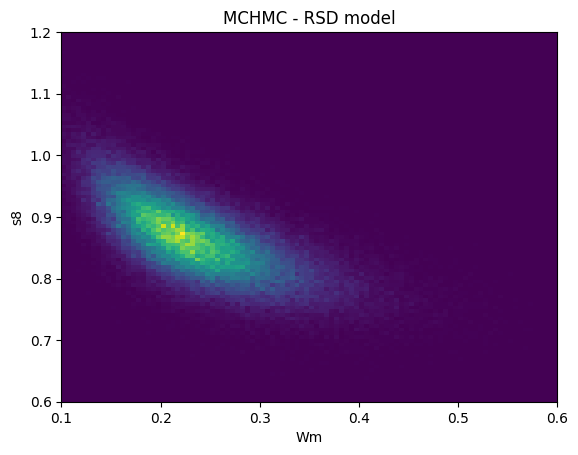

In [71]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [11]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=0.05), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅


eps: 0.5 --> VarE: 2.73616720377689
eps: 0.053433660543926544 --> VarE: 5.654316749942273
eps: 0.0003967309796574555 --> VarE: 0.000833704655444937
eps: 0.0006232344422113107 --> VarE: 0.0025048858995881424
eps: 0.0009563469567440001 --> VarE: 0.002832205121179224
eps: 0.0014367908594431706 --> VarE: 0.003648822864477135
eps: 0.0021148221988587794 --> VarE: 0.0035336459814549605
eps: 0.0030549464482128477 --> VarE: 0.002559112000703923
eps: 0.004337519896516337 --> VarE: 0.014649493822849748
eps: 0.00600530296270079 --> VarE: 0.026708870553358383
eps: 0.00812078361678659 --> VarE: 0.07650085222992399
eps: 0.010499124487376927 --> VarE: 0.2058113562978318
eps: 0.012441329489320318 --> VarE: 0.43071802931469466
eps: 0.012923491546935431 --> VarE: 0.47389005943254603


[ Info: VarE condition met during eps tuning at step: 14
[ Info: Found eps: 0.012923491546935431 ✅


Initial Virial loss: 7506.356197554059
Initial sigma: [1.6840954437362896, 0.3011816025230459]
Virial loss: 84.36128020271319 --> Relative improvement: 0.026292361140158427
Sigma --> [1.6788073792826976, 0.2990127172625004]
Virial loss: 82.09133466395129 --> Relative improvement: 0.02690743352053704
Sigma --> [1.676027847214436, 0.29739633434266327]
Virial loss: 79.85924933514633 --> Relative improvement: 0.02719026725466467
Sigma --> [1.6737705121431585, 0.2959346169108133]
Virial loss: 77.66945239141641 --> Relative improvement: 0.027420705327944717
Sigma --> [1.6716843544448903, 0.29454412229007]
Virial loss: 75.52293325554957 --> Relative improvement: 0.02763659417925879
Sigma --> [1.6696680634016527, 0.2931957346520613]
Virial loss: 73.41982661502757 --> Relative improvement: 0.027847258440103828
Sigma --> [1.6676843521720939, 0.29187649621696793]
Virial loss: 71.35995046401135 --> Relative improvement: 0.028056129331618607
Sigma --> [1.6657172120962644, 0.2905797131098479]
Virial

Virial loss: 8.767123393169507 --> Relative improvement: 0.038372916674228486
Sigma --> [1.5377659152909027, 0.22570130474747743]
Virial loss: 8.421700485550078 --> Relative improvement: 0.039399799926227774
Sigma --> [1.5358411420595315, 0.2249554084568896]
Virial loss: 8.08049588635125 --> Relative improvement: 0.040514929233622876
Sigma --> [1.5339196358336453, 0.22421587441619573]
Virial loss: 7.743585662086307 --> Relative improvement: 0.04169425107115232
Sigma --> [1.5320018463890195, 0.22348263938096183]
Virial loss: 7.4112663179594245 --> Relative improvement: 0.04291543460983005
Sigma --> [1.5300882332400518, 0.22275563062686968]
Virial loss: 7.084034639323317 --> Relative improvement: 0.04415327483822029
Sigma --> [1.5281792784273154, 0.22203476958538615]
Virial loss: 6.762687295829115 --> Relative improvement: 0.045362192571788196
Sigma --> [1.5262754979465845, 0.2213199771214613]
Virial loss: 6.448549357920331 --> Relative improvement: 0.04645164328425011
Sigma --> [1.52437

[ Info: Virial loss condition met during burn-in at step: 95
[ Info: Found sigma: [1.4986572274993262, 0.211304120303579] ✅


eps: 0.012923491546935431 --> VarE: 0.0001866373652387482
eps: 0.01358355769153879 --> VarE: 0.00022925843958718426
eps: 0.014276728151435512 --> VarE: 0.0002854042860053739
eps: 0.015004428717001599 --> VarE: 0.0003575498507506829
eps: 0.015768083343940944 --> VarE: 0.00044867729197286177
eps: 0.016569094420295857 --> VarE: 0.0005625071123629268
eps: 0.01740881472036923 --> VarE: 0.0007037054399452037
eps: 0.018288509484767075 --> VarE: 0.0008780554201109373
eps: 0.01920930717367765 --> VarE: 0.0010926612235448146
eps: 0.020172136056001534 --> VarE: 0.0013562109569271233
eps: 0.021177642751784086 --> VarE: 0.0016789285719003538
eps: 0.02222609634312413 --> VarE: 0.0020710682641514053
eps: 0.02331731088592528 --> VarE: 0.002538590863261646
eps: 0.024450665890378632 --> VarE: 0.0030780192800219566
eps: 0.025625281712336825 --> VarE: 0.0036794829681815484
eps: 0.026840178110257896 --> VarE: 0.0043412567784558735
eps: 0.028094074755282347 --> VarE: 0.00508095600320102
eps: 0.0293848059196

[ Info: VarE condition met during eps tuning at step: 49
[ Info: Found eps: 0.05766275909470686 ✅


In [12]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

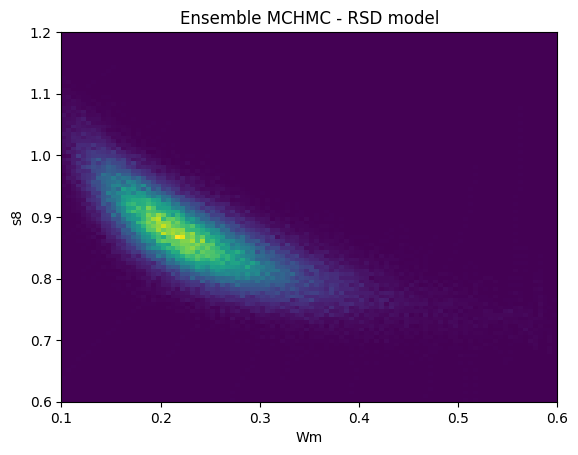

In [13]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [72]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852953733, 0.06088870443747073] ✅


eps: 0.5 --> VarE: 0.6615164942428284
eps: 1.9066281685450561 --> VarE: 11.769314161298977
eps: 0.00017556121679694725 --> VarE: 3.605999657759478e-9
eps: 0.0010724088175124516 --> VarE: 4.7512705333109774e-6
eps: 0.005997359043801121 --> VarE: 0.000985460859641676
eps: 0.03081414667029435 --> VarE: 0.011045309744604492
eps: 0.145034749041523 --> VarE: 0.1007697587267116
eps: 0.5922671087136768 --> VarE: 0.7664013494337432
eps: 1.4127027701748476 --> VarE: 2.6250284875582492
eps: 0.9291692266822086 --> VarE: 1.9945672840752613


[ Info: Found eps: 0.9291692266822086 ✅


samples: 100--> ESS: 0.5227092036058164


[ Info: Found L: 0.7110410302879691 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.47 seconds
Compute duration  = 0.47 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2322    0.0626     0.0006    0.0020   714.4213    1.0045     ⋯
          σ8    0.8684    0.0572     0.0006    0.0017   911.9064    1.0002     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1315    0.1883    0.2249    0.2682    0.3779
          σ8    0.7591    0.8299    0.8675    0.9055    0.9850


In [73]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.46 seconds
Compute duration  = 0.46 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2362    0.0607     0.0006    0.0022   828.3518    0.9999     ⋯
          σ8    0.8649    0.0578     0.0006    0.0020   884.3319    1.0000     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1336    0.1929    0.2303    0.2734    0.3711
          σ8    0.7565    0.8254    0.8627    0.9015    0.9849


## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
[ Info: VarE condition met during eps tuning at step: 7
[ Info: Found eps: 0.008771615483189136 ✅
[ Info: Virial loss condition met during burn-in at step: 29
[ Info: Found sigma: [1.6210966264327005, 0.27798429384397405] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.015346849535888529 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.38 seconds
Compute duration  = 3.38 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2936    0.1603     0.0005    0.0086   226.5623    1.0010     ⋯
          σ8    0.7719    0.2556     0.0008    0.0136   229.4126    1.0376     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0467    0.1696    0.2974    0.4244    0.5792
          σ8    0.2450    0.6034    0.7746    0.9356    1.2669


In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.52 seconds
Compute duration  = 3.52 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2422    0.0770     0.0002    0.0041   231.8493    1.0041     ⋯
          σ8    0.8615    0.0666     0.0002    0.0036   226.0563    1.0295     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1470    0.1999    0.2258    0.2690    0.4739
          σ8    0.7134    0.8121    0.8676    0.9066    0.9891


## Parallelization

In [74]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852953844, 0.06088870443747075] ✅
[ Info: Found sigma: [0.45043479852953844, 0.06088870443747075] ✅
[ Info: Found sigma: [0.45043479852953844, 0.06088870443747075] ✅
[ Info: Found sigma: [0.45043479852953844, 0.06088870443747075] ✅


eps: 0.5 --> VarE: 0.7262054686930772
eps: 0.5 --> VarE: 0.6267334174453069
eps: 0.5 --> VarE: 0.6194135714675568
eps: 1.7871949983744182 --> VarE: 16.16304410551287
eps: 1.988616653418796 --> VarE: 27.39340587230781
eps: 1.97411343124025 --> VarE: 15.982285247604702
eps: 2.518978885013184e-6 --> VarE: 1.8464338655397674e-13
eps: 0.5 --> VarE: 1.551698810073186
eps: 1.538708392158118e-5 --> VarE: 3.514467364157546e-11
eps: 6.429652009001833e-11 --> VarE: 1.5882467046532997e-23
eps: 3.30444592146333e-6 --> VarE: 2.2409757892023184e-13
eps: 8.605136659500277e-5 --> VarE: 9.04257007971987e-9
eps: 3.92752776284479e-10 --> VarE: 5.920277858642567e-22
eps: 2.0185078569094472e-5 --> VarE: 1.586428457619472e-10
eps: 0.782825091355164 --> VarE: 2.10348383232012
eps: 0.0004424847066864485 --> VarE: 1.3320244085600267e-7
eps: 2.1964469230509127e-9 --> VarE: 1.851450529516973e-20
eps: 0.00011288387093783801 --> VarE: 2.1786419651140286e-7
eps: 0.0021006610609310785 --> VarE: 3.373923019463357e-5
e

[ Info: Found eps: 0.7334447106060861 ✅
[ Info: Found L: 1.4484776940056474 ✅


eps: 1.3123598650336608 --> VarE: 3.714972705026253
eps: 0.00014089554063601863 --> VarE: 3.747448866044445e-8
eps: 0.44096471215410726 --> VarE: 0.6213093684556015
eps: 0.4879090630574267 --> VarE: 0.6133397937262209
eps: 0.0004222687758466106 --> VarE: 1.084131538931961e-6
eps: 1.044344086390097 --> VarE: 2.7352683650868137
eps: 0.874456333890559 --> VarE: 1.9711850146403123
samples: 100--> ESS: 0.15337210535053125
eps: 0.001199587478118958 --> VarE: 3.577278181613328e-6
eps: 0.7114467366112955 --> VarE: 1.0117070424898356


[ Info: Found eps: 0.874456333890559 ✅
[ Info: Found L: 2.2806137580024557 ✅


eps: 0.0032386175628449747 --> VarE: 1.1651380211773094e-5
eps: 1.1622026415974547 --> VarE: 4.359928207207119
eps: 0.008330089183106142 --> VarE: 0.00013210582606378634
eps: 0.38119885214453386 --> VarE: 0.56217103356804
eps: 0.020460019868995188 --> VarE: 0.0009638870579206895
eps: 0.7273293206113979 --> VarE: 1.514613344476758
eps: 0.048081169588418404 --> VarE: 0.007088407783099707
eps: 0.8950153464649537 --> VarE: 1.8137909136398989
eps: 0.1081098677220223 --> VarE: 0.04741996753611506
eps: 0.9654051230744594 --> VarE: 2.526580595848789
eps: 0.2300486489857613 --> VarE: 0.16043330806467443
eps: 0.7875268862038733 --> VarE: 1.2875512875857893
eps: 0.4526094310662516 --> VarE: 0.6293243184061237
eps: 1.0235095599575237 --> VarE: 3.028228645033366
eps: 0.731195403070565 --> VarE: 1.1801026288306795
eps: 0.7142097794215573 --> VarE: 0.9971224312153611
eps: 0.9606410862427358 --> VarE: 2.179456380075642
eps: 0.9972541687652638 --> VarE: 2.7286140047057788
eps: 0.9075769639668197 --> Va

[ Info: Found eps: 0.9075769639668197 ✅
[ Info: Found L: 1.885434754546131 ✅


eps: 0.9757474985087081 --> VarE: 2.2123485523172097
eps: 0.918153844841058 --> VarE: 2.0966749101084012
samples: 100--> ESS: 0.13521892501139607


[ Info: Found eps: 0.918153844841058 ✅
[ Info: Found L: 2.7160513064681657 ✅
chain 2:   6%|██▌                                       |  ETA: 0:00:02
chain 4:   5%|██▏                                       |  ETA: 0:00:02

chain 3:   6%|██▌                                       |  ETA: 0:00:02
chain 2:  12%|████▉                                     |  ETA: 0:00:02

chain 4:   9%|███▊                                      |  ETA: 0:00:02
chain 3:  12%|████▉                                     |  ETA: 0:00:02
chain 1:  11%|████▋                                     |  ETA: 0:00:02

chain 2:  17%|███████▏                                  |  ETA: 0:00:02

chain 3:  17%|███████▏                                  |  ETA: 0:00:02
chain 1:  16%|██████▉                                   |  ETA: 0:00:02
chain 4:  13%|█████▌                                    |  ETA: 0:00:02

chain 2:  22%|█████████▌                                |  ETA: 0:00:01
chain 3:  22%|█████████▌                              

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 1:   4%|█▉                                        |  ETA: 0:00:02
chain 3:   4%|█▋                                        |  ETA: 0:00:03
chain 4:   5%|██▏                                       |  ETA: 0:00:02









chain 1:  10%|████▎                                     |  ETA: 0:00:02


chain 3:  10%|████                                      |  ETA: 0:00:02
chain 2:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  11%|████▋                                     |  ETA: 0:00:02

chain 1:  16%|██████▊                                   |  ETA: 0:00:02
chain 3:  15%|██████▎                                   |  ETA: 0:00:02
chain 2:  16%|██████▊                                   |  ETA: 0:00:02
chain 4:  17%|███████▏                                  |  ETA: 0:00:02
chain 1:  22%|█████████                                 |  ETA: 0:00:02
chain 3:  20%|████████▍                                 |  ETA: 0:00:02
chain 4:  23%|███

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 10.62 seconds
Compute duration  = 10.62 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2370    0.0698     0.0007    0.0018   1521.2918    1.0000    ⋯
          σ8    0.8672    0.0634     0.0006    0.0014   2094.1362    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.142682  0.975125  14.8886  37.0  1.0  …  5.0  0.0  0.0408394  0.0408394
 0.213649  0.918899  15.6112  31.0  1.0     4.0  0.0  0.0408394  0.0408394
 0.243588  0.784014  14.5983  23.0  1.0     4.0  0.0  0.0408394  0.0408394
 0.242184  0.805322  15.4589   3.0  1.0     2.0  0.0  0.0408394  0.0408394
 0.221099  0.815317  15.3338  15.0  1.0     3.0  0.0  0.0408394  0.0408394
 0.224389  0.899871  15.9003   3.0  1.0  …  2.0  0.0  0.0408394  0.0408394
 0.219803  0.875915  16.2979   3.0  1.0     2.0  0.0  0.0408394  0.0408394
 0.200948  0.90639   16.0918  15.0  1.0     3.0  0.0  0.0408394  0.0408394
 0.202655  0.930752  15.5048   3.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

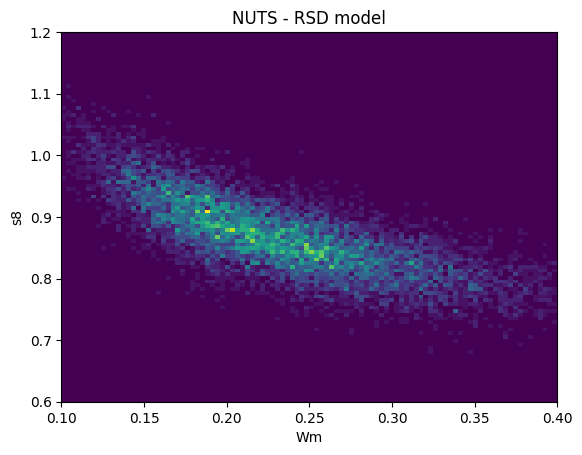

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");